In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree,ensemble,metrics

from rule import Rule
from rule_extraction import rule_extract,draw_tree,rules_vote
from IPython import display

##  1. Data Preparation

In [54]:
# fetch dataset
data = pd.read_csv('./dataset/city_day.csv', usecols = ['PM10', 'NO','CO','Benzene','AQI_Bucket'])
# aqi_class = pd.read_csv('./dataset/city_day.csv', usecols = ['AQI_bucket'])

# drop NA records since most Tree algorithm cannot handle
data.dropna(inplace=True)
res  = []

for i in data['AQI_Bucket']:
    if i=="Good":
        res.append(0)
    elif i=="Satisfactory":
        res.append(1)
    elif i=="Moderate":
        res.append(2)
    elif i=="Poor":
        res.append(3)
    elif i=="Very Poor":
        res.append(4)
    elif i=="Severe":
        res.append(5)
    else:
        res.append(-1)

data["aqi_res"]  = res

# print( len(res) , res(data["AQI_Bucket"]))

# data['aqi_res']= np.where(data['AQI_Bucket']=="Good" ,0 , print('help0'))
# data['aqi_res']= np.where(data['AQI_Bucket']=="Satisfactory" ,1 , print('help1'))
# data['aqi_res']= np.where(data['AQI_Bucket']=="Moderate" ,2 , print('help2'))
# data['aqi_res']= np.where(data['AQI_Bucket']=="Poor" ,3 , print('help3'))
# data['aqi_res']= np.where(data['AQI_Bucket']=="Very Poor" ,4 , print('help4'))
# data['aqi_res']= np.where(data['AQI_Bucket']=="Severe" ,5 , print('help5'))


# # split training/test sets
# X_train, X_test, y_train, y_test = train_test_split(data[['PM10', 'NO','CO','Benzene',"AQI_Bucket",'aqi_res']], 
#                                                     data.aqi_res, test_size=0.2, random_state=0)

# # dataset shape
# print(X_train.shape, X_test.shape)
# print("Train data: \n", X_train.head(5))
# print("Test data: \n", X_test.head(5))


DATA STREAM

In [64]:
from pyflink.common.typeinfo import Types
from pyflink.datastream import StreamExecutionEnvironment
from pyflink import datastream

# Create Streaming Environment
environment = StreamExecutionEnvironment.get_execution_environment()

# define list of users

listed_data = data.values.tolist()


# # define the data types for each user
# PM10', 'NO','CO','Benzene','AQI_Bucket', 'aqi_res'
user_metadata = Types.ROW([
    Types.FLOAT(),
    Types.FLOAT(),
    Types.FLOAT(),
    Types.FLOAT(),
    Types.STRING(),
    Types.INT(),
])

# # Create a Data Stream with list and metadata
data_stream = environment.from_collection(
    collection = listed_data,
    type_info = user_metadata    
)

# Collect all items from stream
stream = data_stream.execute_and_collect()
with data_stream.execute_and_collect() as results:
     for result in results :
         print(result)


<Row(122.41, 15.08, 15.08, 16.44, 'Poor', 3)>
<Row(116.32, 14.67, 14.67, 15.55, 'Very Poor', 4)>
<Row(130.07, 18.02, 18.02, 15.88, 'Very Poor', 4)>
<Row(138.31, 13.27, 13.27, 15.93, 'Very Poor', 4)>
<Row(111.73, 34.56, 34.56, 15.53, 'Severe', 5)>
<Row(118.65, 17.47, 17.47, 15.98, 'Severe', 5)>
<Row(103.88, 11.03, 11.03, 15.31, 'Very Poor', 4)>
<Row(103.3, 11.44, 11.44, 15.6, 'Poor', 3)>
<Row(135.65, 14.29, 14.29, 16.33, 'Very Poor', 4)>
<Row(148.0, 14.31, 14.31, 15.21, 'Very Poor', 4)>
<Row(156.97, 17.96, 17.96, 15.72, 'Severe', 5)>
<Row(177.87, 28.03, 28.03, 17.05, 'Severe', 5)>
<Row(163.36, 21.39, 21.39, 16.47, 'Severe', 5)>
<Row(156.63, 21.02, 21.02, 16.92, 'Severe', 5)>
<Row(140.66, 16.43, 16.43, 16.99, 'Very Poor', 4)>
<Row(153.69, 19.89, 19.89, 17.04, 'Severe', 5)>
<Row(136.34, 16.75, 16.75, 15.68, 'Very Poor', 4)>
<Row(142.06, 23.83, 23.83, 15.5, 'Severe', 5)>
<Row(119.91, 21.8, 21.8, 15.9, 'Severe', 5)>
<Row(134.2, 22.33, 22.33, 14.5, 'Severe', 5)>
<Row(117.51, 20.89, 20.89, 12

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "c:\Users\sanke\AppData\Local\Programs\Python\Python39\lib\site-packages\pyflink\util\exceptions.py", line 146, in deco
    return f(*a, **kw)
  File "c:\Users\sanke\AppData\Local\Programs\Python\Python39\lib\site-packages\py4j\protocol.py", line 326, in get_return_value
    raise Py4JJavaError(
py4j.protocol.Py4JJavaError: An error occurred while calling o553947.next.
: java.util.NoSuchElementException
	at java.util.ArrayList$Itr.next(ArrayList.java:864)
	at sun.reflect.GeneratedMethodAccessor15.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at org.apache.flink.api.python.shaded.py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at org.apache.flink.api.python.shaded.py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at org.apache.flink.api.python.

<Row(170.12, 37.45, 1.21, 1.73, 'Moderate', 2)>
<Row(149.43, 16.31, 0.96, 1.02, 'Poor', 3)>
<Row(173.59, 16.78, 1.03, 1.16, 'Moderate', 2)>
<Row(219.11, 24.78, 1.21, 1.52, 'Poor', 3)>
<Row(244.27, 24.55, 1.27, 1.73, 'Poor', 3)>
<Row(234.67, 35.15, 1.36, 2.15, 'Poor', 3)>
<Row(315.75, 68.88, 1.96, 3.07, 'Very Poor', 4)>
<Row(317.53, 56.44, 1.89, 3.34, 'Very Poor', 4)>
<Row(346.46, 72.82, 2.42, 5.24, 'Very Poor', 4)>
<Row(313.47, 59.65, 1.8, 4.0, 'Very Poor', 4)>
<Row(333.99, 59.63, 1.81, 3.89, 'Very Poor', 4)>
<Row(349.29, 47.09, 1.52, 2.85, 'Very Poor', 4)>
<Row(222.46, 25.0, 1.0, 2.05, 'Very Poor', 4)>
<Row(156.72, 14.44, 0.88, 1.09, 'Moderate', 2)>
<Row(178.51, 24.54, 1.15, 1.93, 'Moderate', 2)>
<Row(279.26, 42.48, 1.47, 2.47, 'Poor', 3)>
<Row(256.86, 45.93, 1.43, 2.3, 'Poor', 3)>
<Row(253.32, 46.05, 1.64, 3.01, 'Poor', 3)>
<Row(205.92, 26.84, 1.18, 1.85, 'Poor', 3)>
<Row(182.26, 25.27, 0.99, 1.63, 'Poor', 3)>
<Row(164.74, 24.87, 0.99, 1.39, 'Moderate', 2)>
<Row(163.52, 15.1, 0.94, 1

KeyboardInterrupt: 

In [65]:
# from pyflink.common.typeinfo import Types
# from pyflink.datastream import StreamExecutionEnvironment
# from pyflink import datastream

# # Create Streaming Environment
# environment = StreamExecutionEnvironment.get_execution_environment()

# # define list of users

# listed_data = data.values.tolist()


# # # define the data types for each user
# # PM10', 'NO','CO','Benzene','AQI_Bucket', 'aqi_res'
# user_metadata = Types.ROW([
#     Types.FLOAT(),
#     Types.FLOAT(),
#     Types.FLOAT(),
#     Types.FLOAT(),
#     Types.STRING(),
#     Types.INT(),
# ])

# # # Create a Data Stream with list and metadata
# data_stream = environment.from_collection(
#     collection = listed_data,
#     type_info = user_metadata    
# )

# # Collect all items from stream
# stream = data_stream.execute_and_collect()
# # with data_stream.execute_and_collect() as results:
# #     for result in results :
# #         print(result)






X_test=[]
X_train=[]
y_test=[]
y_train=[]
i=0
with data_stream.execute_and_collect() as results:
    for result in results :
        if i<4000:
            X_train.append([result[0],result[1],result[2],result[3],result[4],result[5]])
            y_train.append(result[5])
        elif i>=4000 and i< 5000: 
            X_test.append([result[0],result[1],result[2],result[3],result[4],result[5]])
            y_test.append(result[5])
        
        else:
            break
        i = i+1

# # split training/test sets
# X_train, X_test, y_train, y_test = train_test_split(data[['PM10', 'NO','CO','Benzene',"AQI_Bucket",'aqi_res']], 
#                                                     data.aqi_res, test_size=0.2, random_state=0)
# # dataset shape
# print(X_train.shape, X_test.shape)
# print("Train data: \n", X_train.head(5))
# print("Test data: \n", X_test.head(5))



In [66]:
#print(X_test[0],y_test[0], len(X_test))
#print(X_train[0],y_train[0], len(X_train))

X_train = pd.DataFrame(X_train, columns=['PM10', 'NO', 'CO', 'Benzene', 'AQI_Bucket','aqi_res'])
y_train = pd.DataFrame(y_train,columns=['aqi_res'])
X_test = pd.DataFrame(X_test,columns=['PM10', 'NO', 'CO', 'Benzene', 'AQI_Bucket','aqi_res'])
y_test = pd.DataFrame(y_test,columns=['aqi_res'])

# X_test = pd.concat(X_test, keys=['PM10', 'NO','CO','Benzene',"AQI_Bucket"],axis=1)
# X_train= pd.concat(X_train, keys=['PM10', 'NO','CO','Benzene',"AQI_Bucket"],axis=1)
# y_test = pd.concat(y_test,keys='aqi_res',axis=1)
# y_train = pd.concat(y_train,keys='aqi_res',axis=1)

# print(X_train)
X_train.head()


,PM10,NO,CO,Benzene,AQI_Bucket,aqi_res
0,122.41,15.08,15.08,16.44,Poor,3
1,116.32,14.67,14.67,15.55,Very Poor,4
2,130.07,18.02,18.02,15.88,Very Poor,4
3,138.31,13.27,13.27,15.93,Very Poor,4
4,111.73,34.56,34.56,15.53,Severe,5


## 2. Categorical Variable encoding using Mean Encoding

In [67]:
# PM10 mean encoding
X_train.groupby(['PM10'])['aqi_res'].mean()
ordered_labels = X_train.groupby(['PM10'])['aqi_res'].mean().to_dict()
ordered_labels

# Mean Encoding
X_train['PM_ordered'] = X_train.PM10.map(ordered_labels)
X_test['PM_ordered'] = X_test.PM10.map(ordered_labels)


# Sex
X_train.groupby(['NO'])['aqi_res'].mean()
ordered_labels = X_train.groupby(['NO'])['aqi_res'].mean().to_dict()
ordered_labels

# Mean Encoding
X_train['NO_ordered'] = X_train.NO.map(ordered_labels)
X_test['NO_ordered'] = X_test.NO.map(ordered_labels)


# CO mean
X_train.groupby(['CO'])['aqi_res'].mean()
ordered_labels = X_train.groupby(['CO'])['aqi_res'].mean().to_dict()
ordered_labels

# Mean Encoding
X_train['CO_ordered'] = X_train.CO.map(ordered_labels)
X_test['CO_ordered'] = X_test.CO.map(ordered_labels)

# Ben mean 
X_train.groupby(['Benzene'])['aqi_res'].mean()
ordered_labels = X_train.groupby(['Benzene'])['aqi_res'].mean().to_dict()
ordered_labels

# Mean Encoding
X_train['Benzene_ordered'] = X_train.Benzene.map(ordered_labels)
X_test['Benzene_ordered'] = X_test.Benzene.map(ordered_labels)

## 3. Final training data

In [69]:
X_train_proceeded = X_train[['CO_ordered', 'Benzene_ordered','PM_ordered','NO_ordered']]
X_test_proceeded = X_test[['CO_ordered', 'Benzene_ordered','PM_ordered','NO_ordered']]
print(X_train_proceeded.head())

   CO_ordered  Benzene_ordered  PM_ordered  NO_ordered
0         3.0              3.0         3.0         3.0
1         4.0              4.0         4.0         2.5
2         4.0              4.0         4.0         4.0
3         4.0              4.0         4.0         4.0
4         5.0              5.0         5.0         5.0


## 4. Training a Single Decision Tree

In [70]:
# API refer to http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

model_tree_clf = tree.DecisionTreeClassifier(criterion='gini',max_depth=4)
model_tree_clf.fit(X_train_proceeded,y_train)

DecisionTreeClassifier(max_depth=4)

In [71]:
# model performance on training set
y_pred = model_tree_clf.predict(X_train_proceeded)
print(metrics.confusion_matrix(y_train,y_pred))

[[ 331    6    0    0    0    0]
 [   5 1706   52   17    0    0]
 [   0   18 1288   38    1    0]
 [   0    0    6  228    6    0]
 [   0    0    1   14  120    1]
 [   0    0    0    0    2  160]]


SECOND EVALUATION END

##  4.1 Extract all rules without filtering
8 rules in total, corresponding to 8 paths from root to leaf node

In [73]:
rule, _ = rule_extract(model=model_tree_clf,feature_names=X_train_proceeded.columns)
for i in rule:
    print(i)

PM_ordered <= 1.4166666865348816 and PM_ordered <= 0.6500000059604645 and PM_ordered > 0.1666666716337204 and CO_ordered <= 1.2076149582862854
PM_ordered > 1.4166666865348816 and PM_ordered > 2.166666626930237 and CO_ordered > 4.25 and PM_ordered > 2.583333373069763
PM_ordered <= 1.4166666865348816 and PM_ordered > 0.6500000059604645 and PM_ordered <= 1.125 and NO_ordered <= 0.10000000149011612
PM_ordered > 1.4166666865348816 and PM_ordered <= 2.166666626930237 and PM_ordered > 1.8333333134651184 and CO_ordered <= 2.875
PM_ordered <= 1.4166666865348816 and PM_ordered <= 0.6500000059604645 and PM_ordered > 0.1666666716337204 and CO_ordered > 1.2076149582862854
PM_ordered > 1.4166666865348816 and PM_ordered > 2.166666626930237 and CO_ordered <= 4.25 and PM_ordered <= 3.583333373069763
PM_ordered > 1.4166666865348816 and PM_ordered <= 2.166666626930237 and PM_ordered > 1.8333333134651184 and CO_ordered > 2.875
PM_ordered > 1.4166666865348816 and PM_ordered > 2.166666626930237 and CO_order

## 4.2 Output the tree sturcture
compared with the confusion matrix on training data:

 | pred=0 | pred=1
- | :-: | -: 
true=0 | 311 | 34
true=1|  67 |  159

the graph's result match perfectly

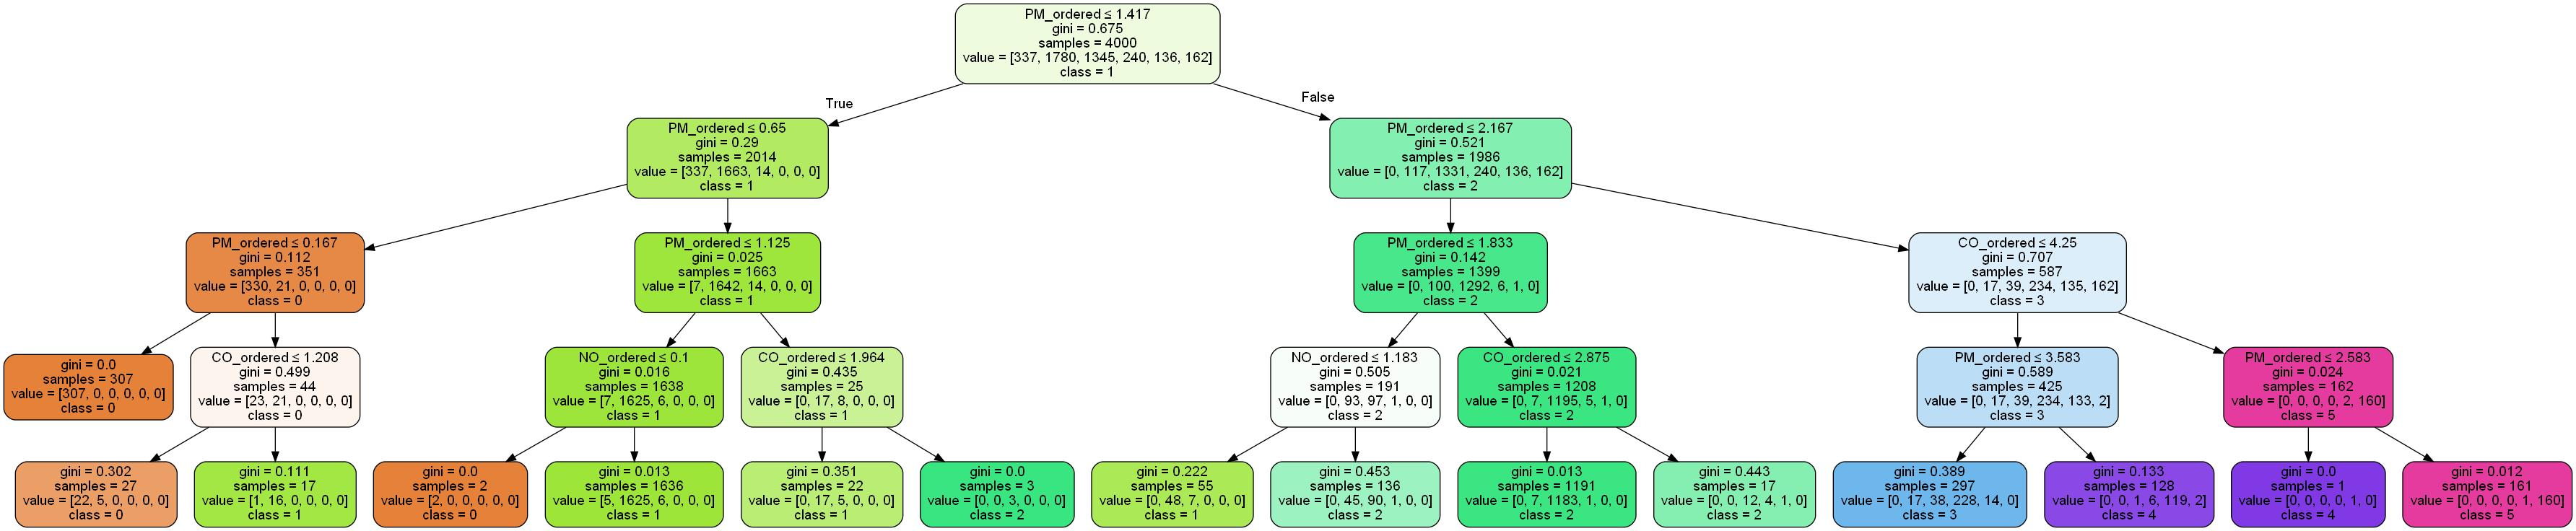

In [74]:
# blue node (class=1) denote the node make prediction of class 1
# orange node (class=0) denote the node make prediction of class 0
#  the darker the color, the more purity the node has 
# values refer to the absolute number of labeled samples in that node
# eg, the 1st leaf node [12,7] means that 12 class 0 samples and 7 class 1 samples are in that node

draw_tree(model=model_tree_clf,
          outdir='./images/DecisionTree/',
          feature_names=X_train_proceeded.columns,
          proportion=False,
          class_names=['0','1', '2', '3', '4','5'])


# importing Image class from PIL package
# from PIL import Image
 
# # creating a object
# im = cv2.imread(r"./images/DecisionTree/DecisionTree.jpeg")
# cv2.imshow('image window', im)

display.Image("./images/DecisionTree/DecisionTree.jpeg")

##  5. Extract rule with filtering
rule_dict:  rule, recall on 1-class, prec on 1-class, recall on 0-class, prec on 0-class, nb


In [46]:
# filter rule
rules, rule_dict = rule_extract(model=model_tree_clf,
                                 feature_names=X_train_proceeded.columns,
                                 x_test=X_test_proceeded,
                                 y_test=y_test,
                                 sort_key=0,
                                 recall_min_c1=0.5,
                                 precision_min_c1=0.5,
                                 recall_min_c0=0.9,
                                 precision_min_c0=0.6)
for i in rule_dict:
    print(i)

KeyError: "None of [Int64Index([478, 815], dtype='int64')] are in the [columns]"

### 5.1 Random Forest

In [11]:
model_RF_clf = ensemble.RandomForestClassifier(max_depth=3,n_estimators=3,random_state=9)
model_RF_clf.fit(X_train_proceeded,y_train)

RandomForestClassifier(max_depth=3, n_estimators=3, random_state=9)

In [12]:
# model performance on test set
y_pred_test = model_RF_clf.predict(X_test_proceeded)
print(metrics.confusion_matrix(y_test,y_pred_test))

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
rules,_ = rule_extract(model=model_RF_clf,feature_names=X_train_proceeded.columns)
for i in rules:
    print(i)

NO_ordered <= 2.464285731315613 and PM_ordered <= 1.3666666746139526 and NO_ordered > 0.8452380895614624
NO_ordered > 2.464285731315613 and NO_ordered <= 4.75 and NO_ordered > 3.875
NO_ordered > 2.464285731315613 and NO_ordered <= 4.75 and NO_ordered <= 3.875
NO_ordered <= 2.464285731315613 and PM_ordered <= 1.3666666746139526 and NO_ordered <= 0.8452380895614624
NO_ordered > 2.464285731315613 and NO_ordered > 4.75
NO_ordered <= 2.464285731315613 and PM_ordered > 1.3666666746139526 and NO_ordered <= 1.050000011920929
NO_ordered <= 2.464285731315613 and PM_ordered > 1.3666666746139526 and NO_ordered > 1.050000011920929
NO_ordered <= 2.8285714387893677 and PM_ordered <= 1.449999988079071 and PM_ordered > 0.550000011920929
NO_ordered > 2.8285714387893677 and PM_ordered <= 3.416666626930237 and CO_ordered <= 4.75
NO_ordered > 2.8285714387893677 and PM_ordered > 3.416666626930237 and PM_ordered > 4.5
NO_ordered <= 2.8285714387893677 and PM_ordered <= 1.449999988079071 and PM_ordered <= 0.55

### 5.2 Output the tree sturcture

In [ ]:
draw_tree(model=model_RF_clf,
          outdir='./images/RandomForest/',
          feature_names=X_train_proceeded.columns,
          proportion=False,
          class_names=['0','1', '2', '3', '4','5'])


### 5.3 BaggingClassifier

In [ ]:
model_bagging_clf = ensemble.BaggingClassifier(
                base_estimator=tree.DecisionTreeClassifier(max_depth=3),
                n_estimators=2,
                n_jobs=-1,
                random_state=0)
model_bagging_clf.fit(X_train_proceeded,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                  n_estimators=2, n_jobs=-1, random_state=0)

In [ ]:
# model performance on test set
y_pred_test = model_bagging_clf.predict(X_test_proceeded)
print(metrics.confusion_matrix(y_test,y_pred_test))

ValueError: Input X contains NaN.
DecisionTreeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
rules,_ = rule_extract(model=model_bagging_clf,feature_names=X_train_proceeded.columns)
for i in rules:
    print(i)

PM_ordered > 1.449999988079071 and PM_ordered <= 2.875 and PM_ordered > 1.774999976158142
PM_ordered <= 1.449999988079071 and PM_ordered <= 0.6333333551883698 and PM_ordered > 0.4166666716337204
PM_ordered > 1.449999988079071 and PM_ordered > 2.875 and PM_ordered <= 3.416666626930237
PM_ordered <= 1.449999988079071 and PM_ordered <= 0.6333333551883698 and PM_ordered <= 0.4166666716337204
PM_ordered > 1.449999988079071 and PM_ordered > 2.875 and PM_ordered > 3.416666626930237
PM_ordered <= 1.449999988079071 and PM_ordered > 0.6333333551883698 and PM_ordered > 1.2916666865348816
PM_ordered > 1.449999988079071 and PM_ordered <= 2.875 and PM_ordered <= 1.774999976158142
PM_ordered <= 1.449999988079071 and PM_ordered > 0.6333333551883698 and PM_ordered <= 1.2916666865348816
PM_ordered > 1.5833333134651184 and PM_ordered > 2.416666626930237 and PM_ordered <= 3.416666626930237
PM_ordered <= 1.5833333134651184 and PM_ordered > 0.4166666716337204 and PM_ordered <= 1.2916666865348816
PM_ordered 

### 5.4 ExtraTree 

In [ ]:
model_extratree_clf = ensemble.ExtraTreesClassifier(max_depth=3,n_estimators=2,random_state=0)
model_extratree_clf.fit(X_train_proceeded,y_train)

ExtraTreesClassifier(max_depth=3, n_estimators=2, random_state=0)

In [ ]:
# model performance on test set
y_pred_test = model_extratree_clf.predict(X_test_proceeded)
print(metrics.confusion_matrix(y_test,y_pred_test))

ValueError: Input X contains NaN.
ExtraTreesClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
rules, _ = rule_extract(model=model_extratree_clf,feature_names=X_train_proceeded.columns)
for i in rules:
    print(i)

PM_ordered <= 3.560427065734019 and Benzene_ordered <= 1.2326572585071705 and PM_ordered <= 1.125024749024317
PM_ordered <= 3.560427065734019 and Benzene_ordered <= 1.2326572585071705 and PM_ordered > 1.125024749024317
PM_ordered > 3.560427065734019 and NO_ordered <= 3.1108104894453708 and PM_ordered <= 4.447820296259671
PM_ordered <= 3.560427065734019 and Benzene_ordered > 1.2326572585071705 and NO_ordered <= 3.222310018363553
PM_ordered > 3.560427065734019 and NO_ordered > 3.1108104894453708 and PM_ordered <= 4.780541413361458
PM_ordered > 3.560427065734019 and NO_ordered <= 3.1108104894453708 and PM_ordered > 4.447820296259671
PM_ordered <= 3.560427065734019 and Benzene_ordered > 1.2326572585071705 and NO_ordered > 3.222310018363553
PM_ordered > 3.560427065734019 and NO_ordered > 3.1108104894453708 and PM_ordered > 4.780541413361458
NO_ordered <= 3.0218657283214228 and PM_ordered > 1.7307919155484028 and Benzene_ordered <= 1.625010709987181
NO_ordered <= 3.0218657283214228 and PM_or

## 6.Rule Voting

### 6.1 Testing our filtering method

in section 5, we have a rule with performance on test set:

('Fare > 26.125 and Pclass_ordered > 0.3504907488822937 and Sex_ordered > 0.4722778648138046', 

recall on 1-class, prec on 1-class, recall on 0-class, prec on 0-class, nb   
(0.328125, 0.9130434782608695, 0.9746835443037974, 0.6416666666666667, 1))

let's check if the result is correct

In [ ]:
one_rule = ['Fare > 26.125 and Pclass_ordered > 0.3504907488822937 and Sex_ordered > 0.4722778648138046']
X_test_proceeded_reindex = X_test_proceeded.reset_index(drop=True)
score = rules_vote(X=X_test_proceeded_reindex,rules=one_rule)
score = pd.DataFrame(score)
print(score[0].value_counts())
score['predict'] = score[0]
score['predict'][score[0]==1] = 1
# this single rule has predicted 23 cases to be positive in test data

0.0    120
1.0     23
Name: 0, dtype: int64


In [ ]:
print(metrics.confusion_matrix(y_test,score.predict))
print('recall in 1-class: ', 21/(21+43))
print('prec   in 1-class: ', 21/(21+2))
print('recall in 0-class: ', 77/(77+2))
print('prec   in 0-class: ', 77/(77+43))

[[77  2]
 [43 21]]
recall in 1-class:  0.328125
prec   in 1-class:  0.9130434782608695
recall in 0-class:  0.9746835443037974
prec   in 0-class:  0.6416666666666667


### 6.2 Random Forest

In [ ]:
# we train a random forest
model_RF_clf = ensemble.RandomForestClassifier(max_depth=3,n_estimators=3,random_state=9)
model_RF_clf.fit(X_train_proceeded,y_train)

RandomForestClassifier(max_depth=3, n_estimators=3, random_state=9)

In [ ]:
# model performance on test set
y_pred_test = model_RF_clf.predict(X_test_proceeded)
print(metrics.confusion_matrix(y_test,y_pred_test))

[[72  7]
 [23 41]]


In [ ]:
# we extract rules from the ensemble with filtering
rules,rule_dict = rule_extract(model=model_RF_clf,
                               feature_names=X_train_proceeded.columns,
                               x_test=X_train_proceeded,
                               y_test=y_train,
                                 sort_key=0,
                                 recall_min_c1=0.1,
                                 precision_min_c1=0.6,
                                 recall_min_c0=0.1,
                                 precision_min_c0=0.5)
print(len(rules))

# we have 5 rule that have prec on class 1>0.6 and recall>0.1

5


In [ ]:
# use the 5 above rules to make prediction again!
X_test_proceeded_reindex = X_test_proceeded.reset_index(drop=True)
#print(X_test_proceeded_reindex)
score = rules_vote(X=X_test_proceeded_reindex,rules=rules)
score = pd.DataFrame(score)
print(score[0].value_counts())

# 6 cases have been voted 3 times. they should be class 1 with greater confidence

0.0    72
1.0    36
2.0    29
3.0     6
Name: 0, dtype: int64


In [ ]:
# we predict all cases that have been voted at least once to be class 1
# if we are more preservative, we can predict class 1 only if they have been 
# voted more times

score['predict'] = score[0]
score['predict'][score[0]>0] = 1
score.head()

,0,predict
0,1.0,1.0
1,2.0,1.0
2,3.0,1.0
3,0.0,0.0
4,1.0,1.0


In [ ]:
# compare this result with the confusion matrix made by the RF model itself
# we can see that 5 rules have a better performace on predicting class 1 samples
print('confusion matrix of RF model')
print(metrics.confusion_matrix(y_test,y_pred_test))
print('confusion matrix of the 5 rules')
print(metrics.confusion_matrix(y_test,score.predict))

confusion matrix of RF model
[[72  7]
 [23 41]]
confusion matrix of the 5 rules
[[58 21]
 [14 50]]
